# Example 2 - Application of LPMs for Data of Two Tracers (Multi-Tracer-Study)

* **General goal**:
    * application of an LPM to model the relationship between two tracers
    * understanding the relationship between two tracers
    * creating and understanding tracer-tracer plots
    * **Note**: this example naturally builds on top of the first example; usually you would fit a LPM (e.g., the exponential model) to both tracers as in the first example and then use the calibrated models (or the calibrated parameter values) to compute the tracer-tracer plot presented here
* Starting from three time series data sets:
    * precipitation measurements
    * tracer concentration in precipitation (tracer / location 1)
    * tracer concentration in precipitation (tracer / location 2)

- **Steps**:
    1. data import and data pre-processing
    2. data visualization
    3. model setup
    4. running the model and analyzing the results
    
**Note: if you are unfamiliar with the `ISOSIMpy` package, do not manipulate any code in this notebook!**

### Step 1: Data Import

#### 1.1 Importing Packages

&rarr; Importing packages

In [1]:
%matplotlib widget

from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
from datetime import datetime
from ipywidgets import *
from Pre import *
from Post import *
from Calculate import *

#### 1.2 Selecting Relevant Files

&rarr; Select files with relevant data
1. Precipitation and source concantration file
    - in directory name "precipitation"
2. Observation well concentration file
    - in directory name "groundwater_samples"

___
___

The following table shows usable combinations of data-sets (select files according to **two rows** of the table):

| **precipitation file** | **groundwater samples file** |
|------------------------|------------------------------|
| precipitation_CFC11    | GW_samples_CFC11             |
| precipitation_CFC12    | GW_samples_CFC12             |
| precipitation_CFC113   | GW_samples_CFC113            |
| precipitation_SF6      | GW_samples_SF6               |
| precipitation_CFC11_3    | GW_samples_CFC11_3             |
| precipitation_CFC12_3    | GW_samples_CFC12_3             |
| precipitation_CFC113_3   | GW_samples_CFC113_3            |
| precipitation_SF6_3      | GW_samples_SF6_3               |
| precipitation_3H_3      | GW_samples_3H_3               |

In [2]:
fc_c = FileChooser(
    os.path.join(os.getcwd(), "model_input", "precipitation"),
    filename='',
    title='<b>Select your time series file of precipitation and concentration for tracer 1:</b>'
)
display(fc_c)

fc_c_2 = FileChooser(
    os.path.join(os.getcwd(), "model_input", "precipitation"),
    filename='',
    title='<b>Select your time series file of precipitation and concentration for tracer 2:</b>'
)
display(fc_c_2)

fc_s = FileChooser(
    os.path.join(os.getcwd(), "model_input", "groundwater_samples"),
    filename='',
    title='<b>Select your file of concentration samples in groundwater for tracer 1:</b>'
)
display(fc_s)

fc_s_2 = FileChooser(
    os.path.join(os.getcwd(), "model_input", "groundwater_samples"),
    filename='',
    title='<b>Select your file of concentration samples in groundwater for tracer 2:</b>'
)
display(fc_s_2)

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\precipitation', filename='', tit…

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\precipitation', filename='', tit…

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\groundwater_samples', filename='…

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\groundwater_samples', filename='…

#### 1.4 Importing and Pre-Processing Data

&rarr; Import and initially pre-process data (set date / time etc.)

In [8]:
try:
    rain = Pre.convertTimeC(pd.read_csv(fc_c.selected, sep=';', header=None))
    rain_2 = Pre.convertTimeC(pd.read_csv(fc_c_2.selected, sep=';', header=None))
    sample = Pre.convertTimeS(pd.read_csv(fc_s.selected, sep=';', header=None))
    sample_2 = Pre.convertTimeS(pd.read_csv(fc_s_2.selected, sep=';', header=None))
    
    sample = sample.drop(sample[sample[3] == 0].index)
    sample_2 = sample_2.drop(sample_2[sample_2[3] == 0].index)
except:
    print('An error occured!')
    
rain = Pre.checkZero(rain)
rain_2 = Pre.checkZero(rain_2)

rain = Pre.weightVolumes(rain)
rain_2 = Pre.weightVolumes(rain_2)

# process well observation data
# merge data on date (we are only interested in observation dates where BOTH tracers are measured)
samples_combined = pd.merge(sample, sample_2, on="Date")

# get the concentration values and drop all other information
values_obs = samples_combined.drop(columns=["0_x", "2_x", "3_x", "Date", "0_y", "2_y", "3_y"]).values

### Step 2: Data Visualization

#### 2.0 Tracer Names

&rarr; Enter the names of your tracers here

In [9]:
name_tracer_1 = "MyTracer1"
name_tracer_2 = "MyTracer2"

#### 2.1 Plotting Source Concentration Data for Both Tracers

&rarr; Plotting data in one single plot

Here you can see your input data


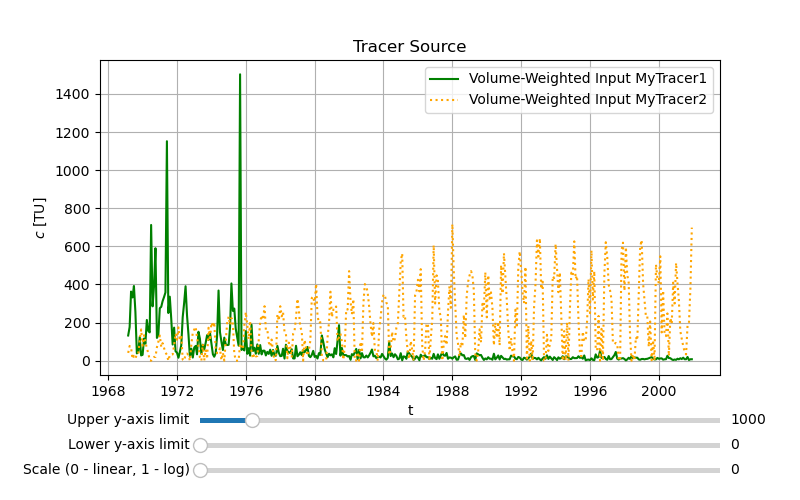

In [10]:
print('Here you can see your input data')
Par.n = 0
fig = plt.figure(figsize=(8, 5), constrained_layout=False)

ax1 = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(bottom=0.25)

ax1.plot(rain['Date'], rain['weighted_c'], label='Volume-Weighted Input %s' % name_tracer_1, color='green')
ax1.plot(rain_2['Date'], rain_2['weighted_c'], label='Volume-Weighted Input %s' % name_tracer_2, color='orange', ls=":")
ax1.legend()
ax1.set(title='Tracer Source',
        ylabel='$c$ [TU]',
        xlabel='t')
ax1.grid()

# create the sliders
ax_scale = fig.add_axes([0.25, 0.05, 0.65, 0.02])
ax_lylim = fig.add_axes([0.25, 0.1, 0.65, 0.02])
ax_uylim = fig.add_axes([0.25, 0.15, 0.65, 0.02])

sscale = Slider(
    ax_scale, "Scale (0 - linear, 1 - log)", int(0), int(1),
    valinit=int(0), valstep=[int(0), int(1)],
    color="green"
)

slylim = Slider(
    ax_lylim, "Lower y-axis limit", 0, 1e2,
    valinit=0.,
    initcolor='none'  # Remove the line marking the valinit position.
)

suylim = Slider(
    ax_uylim, "Upper y-axis limit", 0, 1e4,
    valinit=1000.,
    initcolor='none'  # Remove the line marking the valinit position.
)

def update(val):
    scale = sscale.val
    lylim = slylim.val
    uylim = suylim.val
    if scale == 0:
        ax1.set_yscale("linear")
    elif scale == 1:
        ax1.set_yscale("log")
    ax1.set_ylim(lylim, uylim)
    # fig.canvas.draw_idle()
    
sscale.on_changed(update)
slylim.on_changed(update)
suylim.on_changed(update)

# plt.tight_layout()
plt.show()

### Step 3: Model Setup

#### This is all done in the background...

In [11]:
# instantiate / initialize the parameterization object
Par()

# set initial run / model number
Par.n = 0

# set monthly step (i.e., decay constant is divided by 12 and mean TT is multiplied by 12)
Par.step = 0

# set parameter to NOT include vadose zone calculations
Par.SOILM = 0

# handle recharge according to Par.SOILM
if Par.SOILM == 0:
    print('The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.')
    Cin = rain['weighted_c']
    Cin_2 = rain_2['weighted_c']
elif Par.SOILM == 1:
    pass
elif Par.SOILM == 2:
    pass

The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.


### Step 4: Setting Model Parameters, Running the Model, and Plotting the Results

You will see two `     Run Interact     `-buttons below.

You have to **press the <u>upper button</u> to run the model** with the current parameter values.

You have to **press the <u>lower button</u> to plot the results** with the current plotting settings.

If you want to update anything (model parameters / plotting settings), you have to press the corresponding button for the changes to take effect!
___
___

In [14]:
print('Model type and parameter values:')
def setParameters(model, mean_tt, half_time, half_time_2, pd, eta, TT_min, TT_max, TT_step):
    if model == 'Piston Flow Model':
        Par.MODNUM = 1
    elif model == 'Exponential Model':
        Par.MODNUM = 2
    elif model == 'Dispersion Model':
        Par.MODNUM = 3
    elif model == 'Linear Model':
        Par.MODNUM = 4
    elif model == 'Exponential - Piston Flow Model':
        Par.MODNUM = 5
    Par.TT = mean_tt
    Par.Thalf_1 = half_time
    Par.Thalf_2 = half_time_2
    Par.PD = pd
    Par.eta = eta
    
    """ run model """
    
    # define global variables for results and rsq
    global result
    global rsq
    
    # increase model (run) number
    Par.n += 1
    
    # define times
    global TTs
    TTs = np.arange(TT_min, TT_max, TT_step)
    
    # obtain result
    result = TracerTracer(Par, Cin, Cin_2, rain, rain_2, TTs)
    
    return result

def postprocess_results(year_plot, month_plot, TT_show_1, TT_show_2, TT_show_3, TT_show_4, TT_show_5, TT_show_6, show_observations):
    # TTs = np.arange(TT_min, TT_max, TT_step)
    # show_gw_age = [1., 2., 10., 16., 20., 50., 100.]
    show_gw_age = [TT_show_1, TT_show_2, TT_show_3, TT_show_4, TT_show_5, TT_show_6]
    
    """ handle date of harp diagram """
    # 455 is the month of sampling, so go e.g. 10 years back
    # date = 455-Par.TT
    # date = sampling_month - Par.TT
    plot_date = datetime(year=year_plot, month=month_plot, day=1)
    date = rain.index[rain['Date'] == plot_date].tolist()[0]
    print(date)
    
    # perform (automatic) post-processing
    if show_observations == "Yes":
        fig = Post.tracerTracer(result.result_tt, rain, rain_2, date, show_gw_age, TTs=TTs, tracer_name=name_tracer_1, tracer2_name=name_tracer_2, obs=values_obs)
    else:
        fig = Post.tracerTracer(result.result_tt, rain, rain_2, date, show_gw_age, TTs=TTs, tracer_name=name_tracer_1, tracer2_name=name_tracer_2)
        
    # plt.show()
    
    return fig
    
interact_manual(setParameters,
    model = widgets.RadioButtons(options=['Piston Flow Model',
                                       'Exponential Model',
                                       'Dispersion Model',
                                       'Linear Model',
                                       'Exponential - Piston Flow Model'],
                              layout={'width': 'max-content'},
                              description='Modeltype:',
        style={'description_width': 'initial'}),
    mean_tt = widgets.BoundedIntText(value=10, min=1, max=1e8, step=1,
                                     description='Mean travel time [a]:',
                                    style={'description_width': 'initial'}),
    half_time = widgets.BoundedFloatText(value=10, min=0, max=1e8, step=0.001,
                                         description='Half Life Tracer 1 [a]:',
                                        style={'description_width': 'initial'}),
    half_time_2 = widgets.BoundedFloatText(value=10, min=0, max=1e8, step=0.001,
                                         description='Half Life Tracer 2 [a]:',
                                        style={'description_width': 'initial'}),
    pd = widgets.BoundedFloatText(value=0.1, min=0.01, max=10, step=0.01,
                             description='PD:',
                                 style={'description_width': 'initial'}),
    eta = widgets.BoundedFloatText(value=0.5, min=0.01, max=1, step=0.01,
                             description='eta:',
                                  style={'description_width': 'initial'}),
    TT_min=widgets.BoundedIntText(
        value=2,
        min=1,
        max=200,
        step=1,
        description="Minimum Travel Time to Use",
        style={'description_width': 'initial'}
    ),
    TT_max=widgets.BoundedIntText(
        value=100,
        min=1,
        max=200,
        step=1,
        description="Maximum Travel Time to Use",
        style={'description_width': 'initial'}
    ),
    TT_step=widgets.BoundedIntText(
        value=2,
        min=1,
        max=20,
        step=1,
        description="Interval to Use Between TT_min and TT_max",
        style={'description_width': 'initial'}
    ))

print("\n\n-- !!! The month of sampling is seen from the start of the precipitation time series !!! --\n\n")

interact_manual(
    postprocess_results,
    year_plot=widgets.BoundedIntText(
        value=1980,
        min=1950,
        max=2022,
        step=1,
        description="Year of Plot",
        style={'description_width': 'initial'}
    ),
    month_plot=widgets.BoundedIntText(
        value=1,
        min=1,
        max=12,
        step=1,
        description="Month of Plot",
        style={'description_width': 'initial'}
    ),
    TT_min=widgets.BoundedIntText(
        value=2,
        min=1,
        max=200,
        step=1,
        description="Minimum Travel Time to Use",
        style={'description_width': 'initial'}
    ),
    TT_max=widgets.BoundedIntText(
        value=100,
        min=1,
        max=200,
        step=1,
        description="Maximum Travel Time to Use",
        style={'description_width': 'initial'}
    ),
    TT_step=widgets.BoundedIntText(
        value=2,
        min=1,
        max=20,
        step=1,
        description="Interval to Use Between TT_min and TT_max",
        style={'description_width': 'initial'}
    ),
    TT_show_1=widgets.BoundedIntText(
        value=2,
        min=1,
        max=500,
        step=1,
        description="1st TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    TT_show_2=widgets.BoundedIntText(
        value=5,
        min=1,
        max=500,
        step=1,
        description="2nd TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    TT_show_3=widgets.BoundedIntText(
        value=10,
        min=1,
        max=500,
        step=1,
        description="3rd TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    TT_show_4=widgets.BoundedIntText(
        value=30,
        min=1,
        max=500,
        step=1,
        description="4th TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    TT_show_5=widgets.BoundedIntText(
        value=50,
        min=1,
        max=500,
        step=1,
        description="5th TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    TT_show_6=widgets.BoundedIntText(
        value=100,
        min=1,
        max=500,
        step=1,
        description="6th TT to Mark in Diagram",
        style={'description_width': 'initial'}
    ),
    show_observations=widgets.RadioButtons(options=['Yes', 'No'],
                              layout={'width': 'max-content'},
                              description='Show GW-Observations?',
                              value="No", style={'description_width': 'initial'}),
)
                

Model type and parameter values:


interactive(children=(RadioButtons(description='Modeltype:', layout=Layout(width='max-content'), options=('Pis…



-- !!! The month of sampling is seen from the start of the precipitation time series !!! --




interactive(children=(BoundedIntText(value=1980, description='Year of Plot', max=2022, min=1950, style=Descrip…

<function __main__.postprocess_results(year_plot, month_plot, TT_show_1, TT_show_2, TT_show_3, TT_show_4, TT_show_5, TT_show_6, show_observations)>